In [185]:
import plaidml.keras
plaidml.keras.install_backend()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet

import math

# import pyflux as pf

import warnings
warnings.filterwarnings('ignore')

import itertools

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import autocorrelation_plot

import re

import sys
import os

from functools import reduce

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM
#from keras.layers import Concatenate
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pickle

from numpy.random import seed

from tensorflow import set_random_seed

In [186]:
seed(2019)
set_random_seed(2019)

## Importing Data

In [187]:
df_combined = pd.read_pickle('./processed_data/df_combined.pickle')

In [188]:
df_combined.head(2)

,ds,y,vix,gold
0,2017-02-08 00:00:00,1054.03,18.879,2732.0
1,2017-02-08 01:00:00,1060.48,18.915,2693.0


## Functions

In [189]:
def split_train_test_chronological(df, ratio = 0.9, use_ratio = True, index = 1000):
    
    '''
    Input is a dataframe, and a ratio. Splits dataframe into 2 dataframes chronologically.
    Returns first dataframe up to the index of the length of the input dataframe times the input ratio, 
    and returns second dataframe of remaining elements.
    use_ratio is a flag, wether ratio should be used or indicies instead.
    
    df = input dataframe
    ratio = ratio to be used for splitting
    use_ratio = if True, use ratio, 
    index = index to split input dataframe on
    
    '''
    if use_ratio:
        size = len(df) * ratio
        size_round = round(size)

        df_train = df[0:(size_round)]
        df_test = df[size_round:]
    else:
        df_train = df[0:(index)]
        df_test = df[index:]
    return df_train, df_test

In [190]:
def slice_data(train_perc, stocks_to_trade, return_df_2):
    train_len = int(return_df.shape[0] * (train_perc))
    volume_to_trade = ['v_'+ticker for ticker in stocks_to_trade]
    for i in volume_to_trade:
        stocks_to_trade.append(i)

    train = return_df_2[stocks_to_trade][1:train_len].copy()
    train['diff'] = train[stocks_to_trade[0]] - train[stocks_to_trade[1]]
    train.reset_index(inplace=True, drop=True)

    test = return_df_2[stocks_to_trade][train_len:-400].copy()
    test['diff'] = test[stocks_to_trade[0]] - test[stocks_to_trade[1]]
    test.reset_index(inplace=True, drop=True)

    true_test = return_df_2[stocks_to_trade][-400:].copy()
    true_test['diff'] = true_test[stocks_to_trade[0]] - true_test[stocks_to_trade[1]]
    true_test.reset_index(inplace=True, drop=True)

    feature_names = volume_to_trade
    feature_names.append('diff')
    
    return train, test, true_test, feature_names


In [191]:
def make_variables(df, lags, look_back, predict_window):
    
    '''
    In order to use keras LSTM, we need to convert the input into a keras-friendly input.
    
    df = input dataframe
    lags = number of lags
    look_back = number of preceding elements to be considered
    predict_window = size of window for predictions
    
    '''
    
    features = lags + 1
    start = look_back
    stop = len(df) - lags - predict_window

    lstm_in_X = np.zeros(shape=(stop-start, look_back+1, features))
    lstm_in_Y = np.zeros(shape=(stop-start, look_back+1))

    iter_list = [num for num in range(look_back+1)][::-1]
    for i in range(start, stop):
        for index, j in enumerate(iter_list):
            X = df[i - j : i - j + lags + 1, -1]
            lstm_in_X[i - start, index] = np.ravel(X)
            Y = df[i - j + lags + 1, -1]
            lstm_in_Y[i-start, index] = Y
            
    return lstm_in_X, lstm_in_Y, features

In [192]:
def train_lstm(train_X, train_Y, lags, look_back, predict_window, lstm_nodes,
               dense_layers, dropout = 0.1, loss_type = 'hinge', optimizer_type = 'adam',
               number_epochs = 300, batch_size = 64, ):
    

    model = Sequential()
    model.add(LSTM(lstm_nodes, input_shape=(look_back+1, features)))
    model.add(Dropout(dropout))
    for nodes in dense_layers:
        model.add(Dense(nodes))
        model.add(Dropout(dropout))
    model.add(Dense(look_back + 1))
    model.compile(loss=loss_type, optimizer= optimizer_type)
    model.fit(train_X, train_Y, epochs=number_epochs, batch_size = batch_size, verbose = 1)
    
    pred_Y_train = model.predict(train_X)
    predictions = pred_Y_train[:,-1]
    actuals = train_Y[:,-1]
    
    print(model.summary())
    
    return model, dataset, train_X, train_Y, predictions, actuals

In [193]:
def make_refitting_window(model, train_x, train_y, test_x, test_y):
    predictions_test = []
    actuals_test = []
    
    for i in range(0, len(test_y) - 1):
        model.fit(train_x, train_y, 
                    epochs= 2, 
                    batch_size = 128, 
                    validation_data=(test_x[i].reshape(1,1,23), (test_y[i].reshape(1 ,))),
                    verbose=2,
#                     callbacks=[earlystopper],
                    shuffle=False)
        pred_Y_test = model.predict(test_x)
        train_x = np.concatenate((train_x, (test_x[i].reshape(1 , 1 , 23))))
        le = len(test_y) + 1
        train_y = np.concatenate((train_y, (test_y[i].reshape(1 ,))))
        predict_test = pred_Y_test[-1,-1]
        actual_test = train_x[-1,-1]
        predictions_test.append(predict_test)
        actuals_test.append(actual_test)
        
    
    return predictions_test, actuals_test

In [194]:
#     predictions_test = []
#     actuals_test = []
    
#     for i in range(0, len(test_y) - 1):
#         model.fit(train_x, train_y, 
#                     epochs= 2, 
#                     batch_size = 128, 
# #                     validation_data=(test_x[i], test_y[i]),
#                     verbose=2,
# #                     callbacks=[earlystopper],
#                     shuffle=False)
#         pred_Y_test = model.predict(test_x)
#         test_x = np.concatenate((test_x, (test_x[i].reshape(1 , 1 , 23))))
#         le = len(test_y) + 1
#         test_y = np.concatenate((test_y, (test_y[i].reshape(1 ,))))
#         predict_test = pred_Y_test[-1,-1]
#         actual_test = train_x[-1,-1]
#         predictions_test.append(predict_test)
#         actuals_test.append(actual_test)
        
    
#     return predictions_test, actuals_test

In [195]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    
    
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Train, Val, Test split

In [196]:
df_train, df_test = split_train_test_chronological(df_combined, ratio = .99)

In [197]:
df_train, df_val = split_train_test_chronological(df_combined, ratio = .95)

## Modeling

In [247]:
# load dataset
values = df_combined.drop('ds', axis = 1).values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)

reframed_2 = series_to_supervised(values, 7, 1)
reframed_2.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
7,1054.030029,18.879000,2732.000000,1060.479980,18.915001,2693.000000,1062.939941,18.860001,2712.120117,1065.819946,...,2742.100098,1066.310059,18.878000,2735.270020,1066.060059,18.886999,2732.120117,1066.260010,18.886999,2731.959961
8,1060.479980,18.915001,2693.000000,1062.939941,18.860001,2712.120117,1065.819946,18.770000,2743.989990,1068.150024,...,2735.270020,1066.060059,18.886999,2732.120117,1066.260010,18.886999,2731.959961,1033.900024,18.886999,2710.209961
9,1062.939941,18.860001,2712.120117,1065.819946,18.770000,2743.989990,1068.150024,18.770000,2742.100098,1066.310059,...,2732.120117,1066.260010,18.886999,2731.959961,1033.900024,18.886999,2710.209961,1032.180054,18.886999,2719.310059
10,1065.819946,18.770000,2743.989990,1068.150024,18.770000,2742.100098,1066.310059,18.878000,2735.270020,1066.060059,...,2731.959961,1033.900024,18.886999,2710.209961,1032.180054,18.886999,2719.310059,1037.780029,18.886999,2732.989990
11,1068.150024,18.770000,2742.100098,1066.310059,18.878000,2735.270020,1066.060059,18.886999,2732.120117,1066.260010,...,2710.209961,1032.180054,18.886999,2719.310059,1037.780029,18.886999,2732.989990,1045.300049,18.886999,2719.979980


In [249]:
# drop columns we don't want to predict
y = reframed.iloc[:,-12].values
X = reframed.drop('var1(t)', axis =1).values
# split into train and test sets

n_train_hours = 12000
n_test_hours = 320
train_X = X[:n_train_hours,:]
train_y = y[:n_train_hours]

val_X= X[n_train_hours:-n_test_hours,]
val_y= y[n_train_hours:-n_test_hours]

test_X = X[-n_test_hours:,:]
test_y = y[-n_test_hours:]



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(12000, 1, 23) (12000,) (341, 1, 23) (341,) (320, 1, 23) (320,)


In [250]:
y

array([0.00600698, 0.00590796, 0.00589451, ..., 0.40667784, 0.4065094 ,
       0.40857488], dtype=float32)

In [251]:
# drop columns we don't want to predict
y = reframed_2.iloc[:,-12].values
X = reframed_2.drop('var1(t)', axis =1).values
# split into train and test sets

n_train_hours = 12000
n_test_hours = 320
train_X = X[:n_train_hours,:]
train_y = y[:n_train_hours]

val_X= X[n_train_hours:-n_test_hours,]
val_y= y[n_train_hours:-n_test_hours]

test_X = X[-n_test_hours:,:]
test_y = y[-n_test_hours:]



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(12000, 1, 23) (12000,) (341, 1, 23) (341,) (320, 1, 23) (320,)


In [252]:
    y                          

array([1068.15, 1066.31, 1066.06, ..., 8513.3 , 8510.17, 8548.55],
      dtype=float32)

In [253]:
LSTM_model_3 = Sequential()
LSTM_model_3.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.05,recurrent_dropout=0.05))
LSTM_model_3.add(Dense(64))
# LSTM_model_3.add(LSTM(16, activation='relu'))
LSTM_model_3.add(Dense(1))
LSTM_model_3.compile(optimizer='adam', loss='mse')





In [254]:
history_3 = LSTM_model_3.fit(train_X, train_y, 
                    epochs= 100, 
                    batch_size = 128, 
                    validation_data=(val_X, val_y),
                    verbose=2,
#                     callbacks=[earlystopper],
                    shuffle=False)

Train on 12000 samples, validate on 341 samples
Epoch 1/100
 - 2s - loss: 2131161.6319 - val_loss: 6574.5435
Epoch 2/100
 - 2s - loss: 377113.0051 - val_loss: 11044.5854
Epoch 3/100
 - 2s - loss: 219567.1301 - val_loss: 26958.1064
Epoch 4/100
 - 2s - loss: 177795.6453 - val_loss: 31925.8409
Epoch 5/100
 - 2s - loss: 160762.0327 - val_loss: 30766.4993
Epoch 6/100
 - 2s - loss: 149847.8289 - val_loss: 21392.1235
Epoch 7/100
 - 2s - loss: 106559.2351 - val_loss: 33635.2081
Epoch 8/100
 - 2s - loss: 107983.6157 - val_loss: 25020.7165
Epoch 9/100
 - 2s - loss: 91090.8682 - val_loss: 23595.8687
Epoch 10/100
 - 2s - loss: 96273.6178 - val_loss: 36549.5719
Epoch 11/100
 - 2s - loss: 83795.3022 - val_loss: 29750.4288
Epoch 12/100
 - 2s - loss: 86294.4862 - val_loss: 29835.7802
Epoch 13/100
 - 2s - loss: 87315.1079 - val_loss: 31986.2374
Epoch 14/100
 - 2s - loss: 84525.1099 - val_loss: 26247.5456
Epoch 15/100
 - 2s - loss: 70029.3732 - val_loss: 27757.9982
Epoch 16/100
 - 2s - loss: 69126.2824 

In [255]:
def make_refitting_window(model, train_x, train_y, test_x, test_y):
    predictions_test = []
    actuals_test = []
    
    for i in range(0, len(test_y) - 1):
        model.fit(train_x, train_y, 
                    epochs= 2, 
                    batch_size = 128, 
                    validation_data=(test_x[i].reshape(1,1,23), (test_y[i].reshape(1 ,))),
                    verbose=2,
#                     callbacks=[earlystopper],
                    shuffle=False)
        pred_Y_test = model.predict(test_x)
        train_x = np.concatenate((train_x, (test_x[i].reshape(1 , 1 , 23))))
        le = len(test_y) + 1
        train_y = np.concatenate((train_y, (test_y[i].reshape(1 ,))))
        predict_test = pred_Y_test[-1,-1]
        actual_test = train_y[-1]
        predictions_test.append(predict_test)
        actuals_test.append(actual_test)
        
    
    return predictions_test, actuals_test

In [256]:
res = make_refitting_window(LSTM_model_3, train_X, train_y, val_X, val_y)

Train on 12000 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 14370.6271 - val_loss: 30261.0488
Epoch 2/2
 - 2s - loss: 10952.5091 - val_loss: 27552.6777
Train on 12001 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 11907.7510 - val_loss: 40678.8320
Epoch 2/2
 - 2s - loss: 19194.2698 - val_loss: 37752.6992
Train on 12002 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 12017.1417 - val_loss: 36747.5625
Epoch 2/2
 - 2s - loss: 10322.0354 - val_loss: 36797.5625
Train on 12003 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 11332.9716 - val_loss: 44589.5391
Epoch 2/2
 - 2s - loss: 11150.1828 - val_loss: 48188.5039
Train on 12004 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 9527.5860 - val_loss: 43571.3633
Epoch 2/2
 - 2s - loss: 10170.1304 - val_loss: 42747.1797
Train on 12005 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 15908.2301 - val_loss: 71471.5078
Epoch 2/2
 - 2s - loss: 9895.4899 - val_loss: 68366.2891
Train on 12006 samples, valida

 - 2s - loss: 2445.1336 - val_loss: 41264.4258
Epoch 2/2
 - 2s - loss: 15787.8205 - val_loss: 41077.5703
Train on 12052 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4092.9548 - val_loss: 44912.2266
Epoch 2/2
 - 2s - loss: 2875.4755 - val_loss: 43987.1758
Train on 12053 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4033.9776 - val_loss: 41535.9531
Epoch 2/2
 - 2s - loss: 2569.1348 - val_loss: 44244.8008
Train on 12054 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 6610.1016 - val_loss: 42286.6602
Epoch 2/2
 - 2s - loss: 20534.6023 - val_loss: 46212.6133
Train on 12055 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 3877.2916 - val_loss: 35532.2500
Epoch 2/2
 - 2s - loss: 2872.2407 - val_loss: 37100.1602
Train on 12056 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 2871.9995 - val_loss: 35244.9297
Epoch 2/2
 - 2s - loss: 3318.5837 - val_loss: 36547.6211
Train on 12057 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 7558.5625 - val_loss: 40

Epoch 2/2
 - 2s - loss: 11820.3580 - val_loss: 39069.9219
Train on 12103 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 15744.9515 - val_loss: 33829.1406
Epoch 2/2
 - 2s - loss: 6241.0620 - val_loss: 28928.6445
Train on 12104 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 8947.4229 - val_loss: 38091.2969
Epoch 2/2
 - 2s - loss: 10059.2585 - val_loss: 38271.1484
Train on 12105 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 6959.9166 - val_loss: 38554.6055
Epoch 2/2
 - 2s - loss: 6035.5240 - val_loss: 38829.3945
Train on 12106 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 5695.5381 - val_loss: 40763.2734
Epoch 2/2
 - 2s - loss: 4938.5060 - val_loss: 40358.4180
Train on 12107 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 5307.5006 - val_loss: 42354.9648
Epoch 2/2
 - 2s - loss: 4371.6194 - val_loss: 43726.6289
Train on 12108 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4675.3226 - val_loss: 35345.8359
Epoch 2/2
 - 2s - loss: 3393.7293 - v

Train on 12154 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 3018.9091 - val_loss: 33985.7695
Epoch 2/2
 - 1s - loss: 3384.9646 - val_loss: 33589.4219
Train on 12155 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 1813.3490 - val_loss: 35050.0391
Epoch 2/2
 - 2s - loss: 1274.1789 - val_loss: 33535.1250
Train on 12156 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 3214.4031 - val_loss: 34455.6445
Epoch 2/2
 - 2s - loss: 2997.9793 - val_loss: 35357.6797
Train on 12157 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 1054.0033 - val_loss: 34046.3750
Epoch 2/2
 - 2s - loss: 3158.0352 - val_loss: 35763.8320
Train on 12158 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 2885.1504 - val_loss: 35135.4688
Epoch 2/2
 - 2s - loss: 3475.1056 - val_loss: 36992.6445
Train on 12159 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 13025.9325 - val_loss: 33966.0586
Epoch 2/2
 - 2s - loss: 1299.6383 - val_loss: 35391.2930
Train on 12160 samples, validate on 1 s

 - 2s - loss: 1522.7717 - val_loss: 31906.5410
Epoch 2/2
 - 2s - loss: 963.6547 - val_loss: 31163.7988
Train on 12206 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 1709.4812 - val_loss: 31180.2656
Epoch 2/2
 - 2s - loss: 7188.2541 - val_loss: 31232.1914
Train on 12207 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 1217.7004 - val_loss: 32539.8965
Epoch 2/2
 - 2s - loss: 1911.5238 - val_loss: 32414.4160
Train on 12208 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 1600.7728 - val_loss: 32917.5273
Epoch 2/2
 - 2s - loss: 1099.1366 - val_loss: 31930.0957
Train on 12209 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 959.5872 - val_loss: 32668.6211
Epoch 2/2
 - 2s - loss: 2213.1657 - val_loss: 32323.0527
Train on 12210 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4413.7603 - val_loss: 33016.0273
Epoch 2/2
 - 2s - loss: 3078.3046 - val_loss: 31730.5156
Train on 12211 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 1834.6915 - val_loss: 33005.

 - 2s - loss: 18012.2219 - val_loss: 32151.0469
Train on 12257 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 1121.9767 - val_loss: 34306.2578
Epoch 2/2
 - 2s - loss: 788.4323 - val_loss: 34356.1055
Train on 12258 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 675.9902 - val_loss: 34047.0977
Epoch 2/2
 - 2s - loss: 622.0551 - val_loss: 34920.0742
Train on 12259 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 1398.4084 - val_loss: 34320.0039
Epoch 2/2
 - 2s - loss: 900.9606 - val_loss: 34514.9453
Train on 12260 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 3462.3762 - val_loss: 34114.8828
Epoch 2/2
 - 2s - loss: 2541.8084 - val_loss: 33825.1914
Train on 12261 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 594.9176 - val_loss: 35206.2539
Epoch 2/2
 - 1s - loss: 3537.2722 - val_loss: 34192.1289
Train on 12262 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 1293.2198 - val_loss: 34942.6172
Epoch 2/2
 - 2s - loss: 2012.6399 - val_loss: 35039.16

 - 2s - loss: 890.4464 - val_loss: 33440.8555
Epoch 2/2
 - 2s - loss: 5250.1080 - val_loss: 32474.1348
Train on 12309 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 612.5704 - val_loss: 33406.9336
Epoch 2/2
 - 2s - loss: 1228.9537 - val_loss: 33943.0234
Train on 12310 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 1091.9697 - val_loss: 33058.2695
Epoch 2/2
 - 2s - loss: 1548.6129 - val_loss: 32975.3164
Train on 12311 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 832.1528 - val_loss: 33850.1602
Epoch 2/2
 - 2s - loss: 939.5172 - val_loss: 34668.7852
Train on 12312 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 625.0099 - val_loss: 34447.3945
Epoch 2/2
 - 2s - loss: 2158.1076 - val_loss: 33035.8125
Train on 12313 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 4291.6884 - val_loss: 34129.4062
Epoch 2/2
 - 2s - loss: 807.0260 - val_loss: 34387.2461
Train on 12314 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 1892.2667 - val_loss: 34209.4648

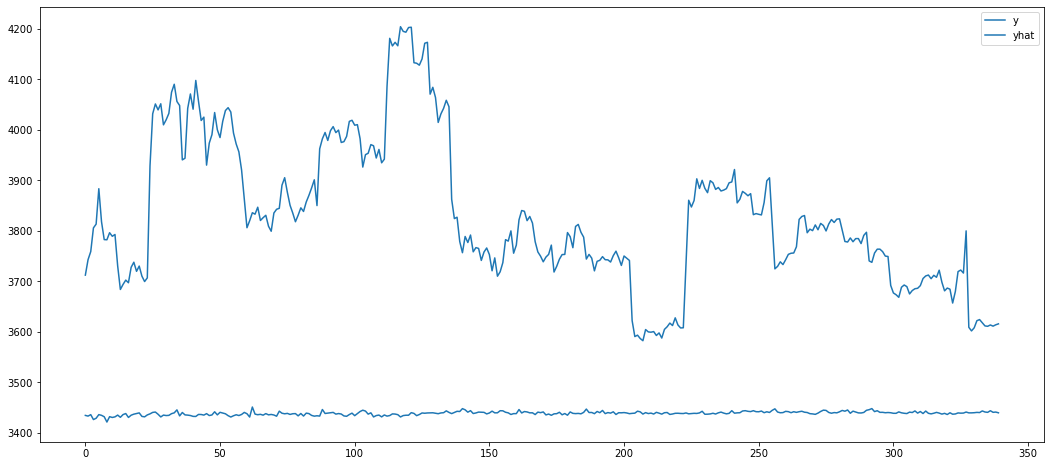

In [257]:
plt.figure(figsize=(18,8))
sns.lineplot(data=pd.DataFrame({'y' : res[1]}))
sns.lineplot(data=pd.DataFrame({'yhat' : res[0]}))

In [258]:
res[0]

[3434.413,
 3433.0493,
 3435.8845,
 3426.1816,
 3428.7656,
 3435.9648,
 3434.5532,
 3431.7764,
 3421.282,
 3431.8796,
 3430.3389,
 3431.5254,
 3435.0134,
 3430.6624,
 3436.0645,
 3438.0942,
 3430.3699,
 3434.8362,
 3436.8806,
 3438.159,
 3439.357,
 3432.4304,
 3431.5596,
 3435.353,
 3437.4746,
 3440.3604,
 3441.0386,
 3436.6724,
 3431.371,
 3435.0383,
 3434.1345,
 3434.485,
 3437.875,
 3439.476,
 3445.3562,
 3433.4536,
 3440.1616,
 3435.413,
 3434.9814,
 3434.1685,
 3432.4915,
 3432.337,
 3436.2932,
 3436.204,
 3435.0232,
 3437.9033,
 3434.1548,
 3435.2903,
 3441.5708,
 3435.4792,
 3440.5352,
 3439.1016,
 3437.6406,
 3433.8948,
 3431.202,
 3433.7192,
 3435.6763,
 3434.161,
 3436.2646,
 3440.3242,
 3437.748,
 3431.1895,
 3451.0125,
 3436.9172,
 3435.767,
 3436.5454,
 3434.8955,
 3437.9607,
 3435.514,
 3436.2888,
 3435.2102,
 3432.8308,
 3442.7935,
 3438.7087,
 3437.6128,
 3438.3945,
 3436.3496,
 3437.7046,
 3437.9727,
 3433.5142,
 3438.169,
 3433.14,
 3438.9004,
 3438.0154,
 3434.393,
 

In [259]:
res[1]

[3712.18,
 3742.8,
 3758.81,
 3805.71,
 3813.19,
 3883.33,
 3818.0,
 3782.54,
 3782.21,
 3796.2,
 3789.11,
 3792.66,
 3730.29,
 3683.78,
 3693.86,
 3702.3,
 3697.13,
 3727.7,
 3737.75,
 3719.7,
 3730.11,
 3710.16,
 3699.47,
 3706.75,
 3928.4,
 4031.7,
 4051.15,
 4039.42,
 4051.51,
 4009.81,
 4019.83,
 4032.44,
 4074.37,
 4090.16,
 4056.07,
 4048.05,
 3940.39,
 3943.7,
 4042.4,
 4070.96,
 4040.78,
 4097.71,
 4056.8,
 4018.45,
 4025.08,
 3930.05,
 3973.58,
 3990.4,
 4034.15,
 4000.04,
 3984.61,
 4016.76,
 4038.09,
 4043.79,
 4035.2,
 3993.59,
 3971.87,
 3956.28,
 3920.44,
 3862.93,
 3806.06,
 3819.92,
 3835.76,
 3832.9,
 3846.68,
 3820.43,
 3825.94,
 3830.71,
 3808.98,
 3799.09,
 3835.21,
 3842.58,
 3844.54,
 3890.3,
 3905.13,
 3876.19,
 3850.44,
 3835.15,
 3817.91,
 3830.85,
 3845.49,
 3838.27,
 3856.92,
 3870.11,
 3884.84,
 3900.95,
 3849.91,
 3962.31,
 3982.13,
 3994.63,
 3978.92,
 3998.2,
 4006.3,
 3994.42,
 3999.43,
 3974.9,
 3976.51,
 3986.94,
 4016.62,
 4018.86,
 4009.1,
 4010.15,

In [222]:
test_y[-1]

30.447

In [243]:
LSTM_model_3.predict(test_X)

array([[34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.44028],
       [34.4

In [244]:
test_y

array([39.267, 39.267, 39.267, 39.267, 39.267, 39.267, 39.267, 39.267,
       39.267, 40.298, 40.198, 39.728, 39.557, 39.488, 39.098, 38.947,
       39.438, 39.438, 39.438, 39.438, 39.438, 39.438, 39.438, 39.438,
       39.438, 39.438, 39.438, 39.438, 39.438, 39.438, 39.438, 39.438,
       39.438, 39.198, 38.427, 37.898, 37.728, 37.688, 37.717, 37.908,
       37.658, 37.658, 37.658, 37.658, 37.658, 37.658, 37.658, 37.658,
       37.658, 37.658, 37.658, 37.658, 37.658, 37.658, 37.658, 37.658,
       37.658, 37.277, 37.368, 37.807, 37.957, 37.728, 37.548, 37.747,
       38.348, 38.348, 38.348, 38.348, 38.348, 38.348, 38.348, 38.348,
       38.348, 38.348, 38.348, 38.348, 38.348, 38.348, 38.348, 38.348,
       38.348, 38.648, 38.137, 38.097, 38.147, 38.067, 37.897, 37.917,
       37.997, 37.997, 37.997, 37.997, 37.997, 37.997, 37.997, 37.997,
       37.997, 37.997, 37.997, 37.997, 37.997, 37.997, 37.997, 37.997,
       37.997, 36.867, 37.247, 36.857, 36.388, 36.657, 36.647, 37.018,
      

In [245]:
df_combined.tail()

,ds,y,vix,gold
12663,2019-06-01 19:00:00,8510.17,30.447,3580.20
12664,2019-06-01 20:00:00,8548.55,30.447,3578.11
12665,2019-06-01 21:00:00,8582.48,30.447,3580.26
12666,2019-06-01 22:00:00,8568.81,30.447,3561.58
12667,2019-06-01 23:00:00,8560.63,30.447,3569.34
